# DeePTB Pardiso Integration - Complete Tutorial

This notebook demonstrates the **complete workflow** for using DeePTB's Pardiso backend for high-performance band structure calculations.

## What You'll Learn
1. **Export Data**: Use `to_pardiso()` to export structure and Hamiltonian data
2. **CLI Integration**: Use `dptb pdso` command for automated workflows
3. **Manual Execution**: Run Julia backend directly for custom workflows
4. **Visualization**: Load and plot band structure results

## Prerequisites
- DeePTB installed with `uv`
- Julia with Pardiso.jl installed
- Trained DeePTB model (`.pth` file)
- Structure file (`.vasp`, `.cif`, etc.)

## Setup

In [20]:
import os
import sys
import json
import subprocess
import numpy as np
import matplotlib.pyplot as plt

# Add DeePTB to path if needed
sys.path.insert(0, os.path.dirname(os.path.dirname(os.getcwd())))
from dptb.postprocess.unified.system import TBSystem

# Define paths
root_dir = os.getcwd()
model_path = os.path.join(root_dir, "nnsk.iter_ovp0.000.pth")
struct_path = os.path.join(root_dir, "min.vasp")
config_path = os.path.join(root_dir, "band.json")

print(f"Model: {model_path}")
print(f"Structure: {struct_path}")
print(f"Config: {config_path}")

Model: /root/soft/DeePTB/examples/To_pardiso/nnsk.iter_ovp0.000.pth
Structure: /root/soft/DeePTB/examples/To_pardiso/min.vasp
Config: /root/soft/DeePTB/examples/To_pardiso/band.json


## Method 1: Python API (Recommended for Scripting)

### Step 1: Initialize TBSystem

In [21]:
tbsys = TBSystem(data=struct_path, calculator=model_path)
print(f"System initialized: {len(tbsys.atoms)} atoms")
print(f"Chemical formula: {tbsys.atoms.get_chemical_formula()}")

System initialized: 84 atoms
Chemical formula: C84


### Step 2: Export Data for Pardiso

The `to_pardiso()` method exports:
- `structure.json`: Structure and basis information (optimized format)
- `predicted_hamiltonians.h5`: Hamiltonian matrix blocks
- `predicted_overlaps.h5`: Overlap matrix blocks (if applicable)

In [22]:
output_dir = os.path.join(root_dir, "out1")
tbsys.to_pardiso(output_dir=output_dir)

print(f"\nExported files:")
for f in sorted(os.listdir(output_dir)):
    fpath = os.path.join(output_dir, f)
    size = os.path.getsize(fpath) / 1024  # KB
    print(f"  {f}: {size:.1f} KB")


Exported files:
  predicted_hamiltonians.h5: 1814.8 KB
  predicted_overlaps.h5: 1814.8 KB
  structure.json: 6.1 KB


### Step 3: Inspect structure.json

In [23]:
with open(os.path.join(output_dir, "structure.json"), 'r') as f:
    structure_data = json.load(f)

print("Structure JSON Schema:")
print(f"  - nsites: {structure_data['structure']['nsites']}")
print(f"  - formula: {structure_data['structure']['chemical_formula']}")
print(f"  - total_orbitals: {structure_data['basis_info']['total_orbitals']}")
print(f"  - spinful: {structure_data['basis_info']['spinful']}")
print(f"  - basis: {structure_data['basis_info']['basis']}")

Structure JSON Schema:
  - nsites: 84
  - formula: C84
  - total_orbitals: 756
  - spinful: False
  - basis: {'C': ['s', 'p', 'd']}


### Step 4: Run Julia Backend Manually

In [24]:
# Locate Julia script
julia_script = os.path.abspath("../../dptb/postprocess/pardiso/main.jl")
results_dir = os.path.join(output_dir, "results")
os.makedirs(results_dir, exist_ok=True)

cmd = [
    "julia",
    julia_script,
    "--input_dir", output_dir,
    "--output_dir", results_dir,
    "--config", config_path
]

print(f"Running: {' '.join(cmd)}\n")
result = subprocess.run(cmd, capture_output=True, text=True)

if result.returncode == 0:
    print("✓ Julia calculation completed successfully")
else:
    print(f"✗ Julia execution failed with code {result.returncode}")
    print(result.stderr)

Running: julia /root/soft/DeePTB/dptb/postprocess/pardiso/main.jl --input_dir /root/soft/DeePTB/examples/To_pardiso/out1 --output_dir /root/soft/DeePTB/examples/To_pardiso/out1/results --config /root/soft/DeePTB/examples/To_pardiso/band.json

✓ Julia calculation completed successfully


## Method 2: CLI Integration (Recommended for Production)

The `dptb pdso` command provides a streamlined interface that handles both export and execution.

In [25]:
# Clean up previous output
cli_output_dir = os.path.join(root_dir, "out2")

cmd = [
    "dptb", "pdso",
    config_path,
    "-i", model_path,
    "-stu", struct_path,
    "-o", cli_output_dir
]

print(f"Running: {' '.join(cmd)}\n")
result = subprocess.run(cmd, capture_output=True, text=True)

if result.returncode == 0:
    print("✓ CLI workflow completed successfully")
    print(f"\nResults saved to: {os.path.join(cli_output_dir, 'results')}")
else:
    print(f"✗ CLI execution failed")
    print(result.stderr)

Running: dptb pdso /root/soft/DeePTB/examples/To_pardiso/band.json -i /root/soft/DeePTB/examples/To_pardiso/nnsk.iter_ovp0.000.pth -stu /root/soft/DeePTB/examples/To_pardiso/min.vasp -o /root/soft/DeePTB/examples/To_pardiso/out2

✓ CLI workflow completed successfully

Results saved to: /root/soft/DeePTB/examples/To_pardiso/out2/results


## Visualize Results

Load and plot the band structure from Julia output.

Loading results from /root/soft/DeePTB/examples/To_pardiso/out2/results/bandstructure.h5...
Successfully loaded bandstructure.h5
Eigenvalues shape: (31, 30)


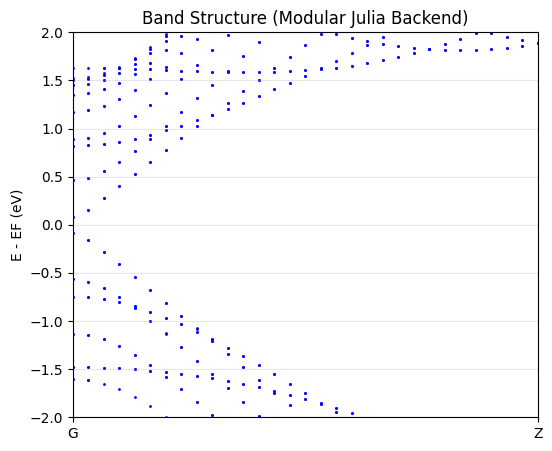

In [26]:
import h5py
import matplotlib.pyplot as plt

expected_h5 = os.path.join(cli_output_dir, 'results', "bandstructure.h5")
print(f"Loading results from {expected_h5}...")
with h5py.File(expected_h5, 'r') as f:
    evals = f['eigenvalues'][:]
    x = f['xlist'][:]
    e_fermi = f['E_fermi'][()]
    high_sym_kpoints = f['high_sym_kpoints'][:]
    labels_bytes = f['labels'][:]
    
# Decode labels from bytes to string
try:
    labels = [l.decode('utf-8') for l in labels_bytes]
except AttributeError:
    # If already strings
    labels = list(labels_bytes)


print(f"Successfully loaded bandstructure.h5")
print(f"Eigenvalues shape: {evals.shape}")

plt.figure(figsize=(6,5))

evals_shifted = evals - e_fermi
for i in range(evals.shape[1]): # Loop over bands
    plt.scatter(x, evals_shifted[:, i], s=1, c='blue') 
    
plt.xticks(high_sym_kpoints, labels)
plt.xlim(0,x[-1])
plt.ylim(-2,2)
plt.ylabel('E - EF (eV)')
plt.title('Band Structure (Modular Julia Backend)')
plt.grid(True, alpha=0.3)
plt.show()

## Advanced: Backward Compatibility

The Julia backend can also read legacy `.dat` files if `structure.json` is missing.

To export in legacy format for debugging:

In [ ]:
legacy_dir = os.path.join(root_dir, "legacy_export")
tbsys.to_pardiso_debug(output_dir=legacy_dir)

print("Legacy export files:")
for f in sorted(os.listdir(legacy_dir)):
    print(f"  {f}")

## Summary

**Key Takeaways:**
1. **Standard Workflow**: Use `tbsys.to_pardiso()` for JSON export (recommended)
2. **CLI**: Use `dptb pdso` for automated export + calculation
3. **Manual Control**: Call `main.jl` directly for custom workflows
4. **Backward Compatibility**: Legacy `.dat` format still supported via `to_pardiso_debug()`

**Performance Tips:**
- Sparse matrices are cached in `sparse_matrix.jld` for faster subsequent runs
- Enable `--ill_project` for systems with near-singular overlap matrices
- Adjust `num_band` and `max_iter` in config for convergence

**Next Steps:**
- Try DOS calculations by changing `task: "dos"` in config
- Explore different k-paths and energy windows
- Integrate into automated workflows using `dptb pdso`